In [1]:
import pandas as pd                 
import numpy as np                                       
import sklearn.model_selection     # For using KFold
import datetime                    # To measure running time 
import skimage.transform           # For resizing images
import skimage.morphology          # For using image labeling
import cv2                         # To read and manipulate images
import os                          # For filepath, directory handling
import sys                         # System-specific parameters and functions
import tqdm                        # Use smart progress meter
import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
%matplotlib inline  

import time
import glob

In [2]:
# https://www.kaggle.com/jakubczakon/morphological-postprocessing-on-unet-lb-0-429
import skimage.morphology as morph
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi
from scipy.stats import itemfreq

from itertools import product


In [3]:
def mask_to_contour_overlay(mask, image=None, color=[255,255,255]):

    height,width = mask.shape[:2]
    overlay = np.zeros((height,width,3),np.uint8) if image is None else image.copy()

    num_instances = int(mask.max())
    if num_instances==0: return overlay

    for i in range(num_instances):
        overlay[mask_to_inner_contour(mask==i+1)]=color

    return overlay

# modifier  ----------------------------------------------------------------

def mask_to_outer_contour(mask):
    pad = np.lib.pad(mask, ((1, 1), (1, 1)), 'reflect')
    contour = (~mask) & (
            (pad[1:-1,1:-1] != pad[:-2,1:-1]) \
          | (pad[1:-1,1:-1] != pad[2:,1:-1])  \
          | (pad[1:-1,1:-1] != pad[1:-1,:-2]) \
          | (pad[1:-1,1:-1] != pad[1:-1,2:])
    )
    return contour

def mask_to_inner_contour(mask):
    pad = np.lib.pad(mask, ((1, 1), (1, 1)), 'reflect')
    contour = mask & (
            (pad[1:-1,1:-1] != pad[:-2,1:-1]) \
          | (pad[1:-1,1:-1] != pad[2:,1:-1])  \
          | (pad[1:-1,1:-1] != pad[1:-1,:-2]) \
          | (pad[1:-1,1:-1] != pad[1:-1,2:])
    )
    return contour

In [4]:
def plot_list(images, labels):
    n_img = len(images)
    n_lab = len(labels)
    n = n_lab+n_img
    plt.figure(figsize=(12,8))
    for i, image in enumerate(images):
        plt.subplot(1,n,i+1)
        plt.imshow(image)
    for j, label in enumerate(labels):
        plt.subplot(1,n,n_img+j+1)
        plt.imshow(label, cmap='nipy_spectral')
    plt.show()
    
def mean_blob_size(mask):
    labels, labels_nr = ndi.label(mask)
    if labels_nr < 2:
        mean_area = 1
        mean_radius = 1
    else:
        mean_area = int(itemfreq(labels)[1:, 1].mean())
        mean_radius = int(np.round(np.sqrt(mean_area) / np.pi))
    return mean_area, mean_radius

def pad_mask(mask, pad):
    if pad <= 1:
        pad = 2
    h, w = mask.shape
    h_pad = h + 2 * pad
    w_pad = w + 2 * pad
    mask_padded = np.zeros((h_pad, w_pad))
    mask_padded[pad:pad + h, pad:pad + w] = mask
    mask_padded[pad - 1, :] = 1
    mask_padded[pad + h + 1, :] = 1
    mask_padded[:, pad - 1] = 1
    mask_padded[:, pad + w + 1] = 1

    return mask_padded

def crop_mask(mask, crop):
    if crop <= 1:
        crop = 2
    h, w = mask.shape
    mask_cropped = mask[crop:h - crop, crop:w - crop]
    return mask_cropped


def watershed_v3(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    labels = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    
    labels = add_dropped_water_blobs(labels, cleaned_mask)
    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)
    labels = drop_artifacts_per_label(labels,initial_mask_binary)
    
    labels = drop_small(labels, min_size=20)
    labels = fill_holes_per_blob(labels)
        
    return labels



def relabel(img):
    h, w = img.shape

    relabel_dict = {}

    for i, k in enumerate(np.unique(img)):
        if k == 0:
            relabel_dict[k] = 0
        else:
            relabel_dict[k] = i
    for i, j in product(range(h), range(w)):
        img[i, j] = relabel_dict[img[i, j]]
    return img

def drop_small(img, min_size):
    img = morph.remove_small_objects(img, min_size=min_size)
    return relabel(img)

def fill_holes_per_blob(image):
    image_cleaned = np.zeros_like(image)
    for i in range(1, image.max() + 1):
        mask = np.where(image == i, 1, 0)
        mask = ndi.morphology.binary_fill_holes(mask)
        image_cleaned = image_cleaned + mask * i
    return image_cleaned


def good_distance_v1(m_b):
    distance = ndi.distance_transform_edt(m_b)
    return distance

def add_dropped_water_blobs(water, mask_cleaned):
    water_mask = (water > 0).astype(np.uint8)
    dropped = mask_cleaned - water_mask
    dropped, _ = ndi.label(dropped)
    dropped = np.where(dropped, dropped + water.max(), 0)
    water = water + dropped
    return water

def drop_artifacts_per_label(labels, initial_mask):
    labels_cleaned = np.zeros_like(labels)
    for i in range(1, labels.max() + 1):
        component = np.where(labels == i, 1, 0)
        component_initial_mask = np.where(labels == i, initial_mask, 0)
        component = drop_artifacts(component, component_initial_mask)
        labels_cleaned = labels_cleaned + component * i
    return labels_cleaned


def clean_mask_v2(m,c):
    # threshold
    m_b = m > threshold_otsu(m)
    c_b = c > threshold_otsu(c)

    # combine contours and masks and fill the cells
    m_ = np.where(m_b | c_b, 1, 0)
    m_ = ndi.binary_fill_holes(m_)

    # close what wasn't closed before 
    area, radius = mean_blob_size(m_b)
    struct_size = int(1.25*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(m_, pad=struct_size)
    m_padded = morph.binary_closing(m_padded, selem=struct_el)
    m_ = crop_mask(m_padded, crop=struct_size)
    
    # open to cut the real cells from the artifacts
    area, radius = mean_blob_size(m_b)
    struct_size = int(0.75*radius)
    struct_el = morph.disk(struct_size)
    m_ = np.where(c_b & (~m_b), 0, m_)
    m_padded = pad_mask(m_, pad=struct_size)
    m_padded = morph.binary_opening(m_padded, selem=struct_el)
    m_ = crop_mask(m_padded, crop=struct_size)

    # join the connected cells with what we had at the beginning
    m_ = np.where(m_b|m_,1,0)
    m_ = ndi.binary_fill_holes(m_)
    
    # drop all the cells that weren't present at least in 25% of area in the initial mask 
    m_ = drop_artifacts(m_, m_b,min_coverage=0.25)
    
    return m_

def drop_artifacts(mask_after, mask_pre, min_coverage=0.5):
    connected, nr_connected = ndi.label(mask_after)
    mask = np.zeros_like(mask_after)
    for i in range(1, nr_connected + 1):
        conn_blob = np.where(connected == i, 1, 0)
        initial_space = np.where(connected == i, mask_pre, 0)
        blob_size = np.sum(conn_blob)
        initial_blob_size = np.sum(initial_space)
        coverage = float(initial_blob_size) / float(blob_size)
        if coverage > min_coverage:
            mask = mask + conn_blob
        else:
            mask = mask + initial_space
    return mask


def good_markers_v3(m_b,c):
    # threshold
    c_b = c > threshold_otsu(c)
    
    mk_ = np.where(c_b,0,m_b)
    
    area, radius = mean_blob_size(m_b)
    struct_size = int(0.25*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(mk_, pad=struct_size)
    m_padded = morph.erosion(m_padded, selem=struct_el)
    mk_ = crop_mask(m_padded, crop=struct_size)
    mk_,_ = ndi.label(mk_) 
    return mk_



In [5]:
m1 = np.load('/home/jun/20180330/results/mask-rcnn-50-gray500-02/submit/npys/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.npy')

In [6]:
c1 = mask_to_contour_overlay(m1)
c1 = c1[:,:,0]/255

In [7]:
np.unique(c1)

array([0., 1.])

In [8]:
l = watershed_v3(m1, c1)

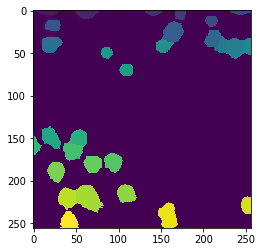

In [9]:
plt.imshow(l)

In [10]:
np.unique(l)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [11]:
np.unique(m1)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43.], dtype=float32)